### Pull the AQI from EPA API
The goal of this notebook is to extract AQI measurements from monitoring stations in Missoula county. These will serve as a proxy for the air quality in the area which we will use to contrast with our smoke estimate.

In [1]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### EPA API

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

USERNAME = "evan@yipsite.net"
APIKEY = 'bolewolf74'

#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   


CITY_LOCATIONS = {
    'missoula' :       {'city'   : 'Missoula',
                       'county' : 'Missoula',
                       'state'  : 'Montana',
                       'fips'   : '30063',
                       'latlon' : [46.8721, -113.9940] }
}


In [3]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [4]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

def check_request_daily_summary_response(response):
    if response["Header"][0]['status'] == "Success":
        return True
    elif response["Header"][0]['status'].startswith("No data "):
        return False


In [5]:

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['missoula']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['missoula']['fips'][2:]

gaseous_list = []
particulate_list = []

start_year = 1963
end_year = 2023

for year in range(start_year, end_year + 1):
    start_date = f"{year}0501"
    end_date = f"{year}1031"
    request_data['param'] = AQI_PARAMS_GASEOUS
    # request daily summary data for the month of July in 2021
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=end_date)
    if check_request_daily_summary_response(gaseous_aqi):
        gaseous_data = gaseous_aqi['Data']
        gaseous_list.append(gaseous_data)
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=end_date)
    if check_request_daily_summary_response(particulate_aqi):
        particulate_data = particulate_aqi['Data']
        particulate_list.append(particulate_data)
    
    if (year - start_year + 1) % 10 == 0:
        print(f"{year - start_year + 1} years extracted")


10 years extracted
20 years extracted
30 years extracted
40 years extracted
50 years extracted
60 years extracted


Below we are iterating through the lists of the gases and the particulates and compiling it into a single dataframe.

In [6]:
i = 0
for years in gaseous_list:
    for months in years:
        if i == 0:
            aqi_df = pd.DataFrame(months, index=[i])[['site_number', 'parameter', 'date_local', 'aqi']]
        else:
            aqi_df = pd.concat([aqi_df, pd.DataFrame(months, index=[i])[['site_number', 'parameter', 'date_local', 'aqi']]])
        i += 1

for years in particulate_list:
    for months in years:
        aqi_df = pd.concat([aqi_df, pd.DataFrame(months, index=[i])[['site_number', 'parameter', 'date_local', 'aqi']]])

Finally we perform aggregations to get the average AQI across each fire season. First we take the max aqi reading across all particulates for a specific site on a specific day. Then we aggregate this again across all other nearby stations, computing the mean. This average is then aggregated another time across the whole year (or fire season in this case). Now we are done!

In [24]:

aqi_clean = aqi_df.copy()
aqi_clean['aqi'] = aqi_df['aqi'].replace({None: np.nan}).astype(float)
aqi_clean = aqi_clean.dropna(subset=['aqi'])

In [123]:
# Computing the max aqi per day and per station (max of all different components that day)
aqi_max_per_station_per_day = aqi_clean.groupby(['site_number', 'date_local']).max().reset_index()

# Computing the max aqi per day across all stations
aqi_max_per_day = aqi_max_per_station_per_day.groupby(['date_local']).max().reset_index()

# Extracting the year
aqi_max_per_day['year'] = pd.to_datetime(aqi_max_per_day['date_local']).dt.year
# aqi_avg_per_day['year'] = pd.to_datetime(aqi_avg_per_day['date_local']).dt.year

# Filtering for number of days during the fire season with AQI > 75 or AQI > 100
aqi_max_per_day['aqi100'] = np.where(aqi_max_per_day['aqi'] > 100, 1, 0)
aqi_max_per_day['aqi75'] = np.where(aqi_max_per_day['aqi'] > 75, 1, 0)

# Computing the average and max aqi per year
aqi_avg_per_year = aqi_max_per_day[['year', 'aqi']].groupby('year').mean().reset_index()
aqi_max_per_year = aqi_max_per_day[['year', 'aqi']].groupby('year').max().reset_index()

# Renaming columns
aqi_avg_per_year = aqi_avg_per_year.rename(columns={"aqi": "avg_aqi"})
aqi_max_per_year = aqi_max_per_year.rename(columns={"aqi": "max_aqi"})
# Computing the count of number of days with AQI greater than 100 and 75
aqi100 = aqi_max_per_day[['year', 'aqi100']].groupby('year').sum().reset_index()[['year', 'aqi100']]
aqi75 = aqi_max_per_day[['year', 'aqi75']].groupby('year').sum().reset_index()[['year', 'aqi75']]

# Joining all the aqi tables together
final_aqi_df = pd.concat([aqi_max_per_year, aqi_avg_per_year[['avg_aqi']], aqi100['aqi100'], aqi75['aqi75']], axis=1)
final_aqi_df.to_csv("../data_intermediate/montana_aqi.csv", index=False)

Text(0, 0.5, 'AQI')

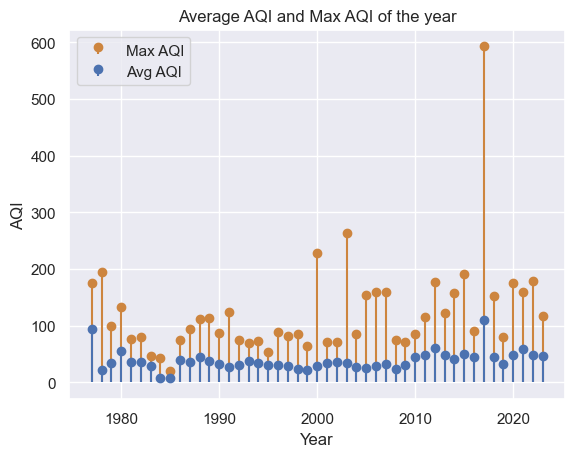

In [115]:
colors = sns.color_palette()
plt.stem(aqi_max_per_year['year'], aqi_max_per_year['max_aqi'], linefmt="peru", basefmt=' ', label='Max AQI')
plt.stem(aqi_avg_per_year['year'], aqi_avg_per_year['avg_aqi'], basefmt=' ',label='Avg AQI')
plt.legend()
plt.title("Average AQI and Max AQI of the year")
plt.xlabel("Year")
plt.ylabel("AQI")

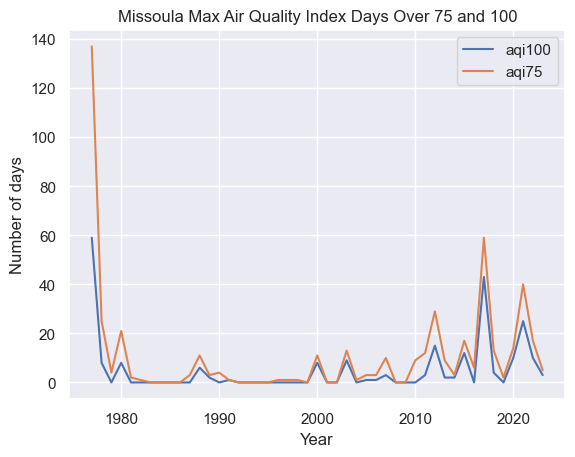

In [124]:
plt.plot(aqi100['year'], aqi100['aqi100'], label='aqi100')
plt.plot(aqi75['year'], aqi75['aqi75'], label='aqi75')
plt.legend()
plt.title("Missoula Max Air Quality Index Days Over 75 and 100")
plt.xlabel("Year")
plt.ylabel("Number of days")
plt.show()

In [127]:
aqi_df['parameter'].unique()

array(['Sulfur dioxide', 'Nitrogen dioxide (NO2)', 'Carbon monoxide',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions',
       'Acceptable PM2.5 AQI & Speciation Mass'], dtype=object)